In [59]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [171]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [61]:
y.shape, tx.shape

((10000,), (10000, 2))

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_cost` function below:

In [28]:


def compute_loss(y, tx, w):

    """Calculate the loss using either MSE or MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    e = y - np.dot(tx,w)
    N = y.shape[0]
   
    return 1/(2*N) * np.dot(e.T,e)
    # TODO: compute loss by MSE
    # ***************************************************
    raise NotImplementedError


In [39]:
w = np.array([1,2]).T
e = y - np.dot(tx,w)
loss = compute_loss(y, tx, w)
np.linspace(0,100,10)

array([  0.        ,  11.11111111,  22.22222222,  33.33333333,
        44.44444444,  55.55555556,  66.66666667,  77.77777778,
        88.88888889, 100.        ])

# 2. Grid Search

Fill in the function `grid_search()` below:

In [156]:
# from costs import *

def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.
        
    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    for i in range(len(grid_w0)):
        for j in range(len(grid_w1)):
            w = np.array([grid_w0[i],grid_w1[j]]).T
            losses[i,j] = compute_loss(y,tx,w)
    
    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************
    
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=71.1270196108493, w0*=71.42857142857142, w1*=9.183673469387742, execution time=0.052 seconds


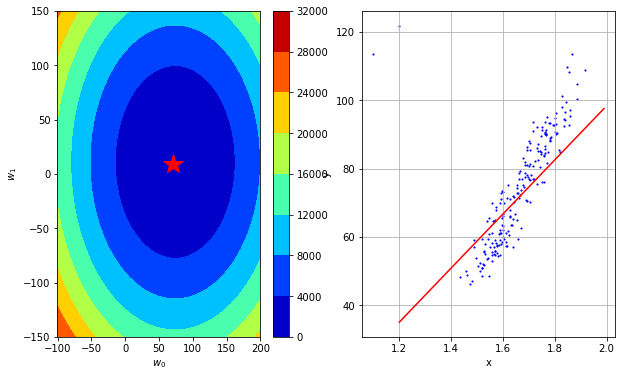

In [157]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=50)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0,6.0)
fig.savefig("grid_plot")  # Optional saving

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [51]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    N = y.shape[0]
    e = y - np.dot(tx,w)
    return -1/N*np.dot(tx.T,e)
    # TODO: compute gradient vector
    # ***************************************************
    

In [58]:
#test
yb = np.array([1,2,3]).T
txb = np.c_[np.array([1,1,1]),np.array([1,2,3])]
wb = np.array([1,2]).T
print(compute_gradient(yb, txb, wb))
print(20/3)
#OK

[3.         6.66666667]
6.666666666666667


In [82]:
#intuition
w1 = np.array([100,20]).T
w2 = np.array([50,10]).T
print(compute_gradient(y, tx, w1))
print(compute_gradient(y, tx, w2))

[26.706078    6.52028757]
[-23.293922    -3.47971243]


Please fill in the functions `gradient_descent` below:

In [89]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of GD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        grad = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        # ***************************************************
  
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        w = w - gamma*grad
        # ***************************************************
   
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}, grad={grad}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1], grad=grad))

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [91]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1

# Initialization
w_initial = np.array([-1000, 1000])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=1062606.4462798769, w0=-892.6706077997898, w1=901.3479712434981, grad=[-1073.293922     986.52028757]
GD iter. 1/49: loss=860714.1448053946, w0=-796.0741548196002, w1=812.561145362647, grad=[-965.9645298   887.86825881]
GD iter. 2/49: loss=697181.3806110646, w0=-709.1373471374294, w1=732.6530020698813, grad=[-869.36807682  799.08143293]
GD iter. 3/49: loss=564719.8416136572, w0=-630.8942202234758, w1=660.7356731063917, grad=[-782.43126914  719.17328963]
GD iter. 4/49: loss=457425.9950257571, w0=-560.4754060009178, w1=596.0100770392514, grad=[-704.18814223  647.25596067]
GD iter. 5/49: loss=370517.9792895583, w0=-497.09847320061544, w1=537.757040578825, grad=[-633.769328   582.5303646]
GD iter. 6/49: loss=300122.48654323735, w0=-440.05923368034337, w1=485.3293077644414, grad=[-570.3923952   524.27732814]
GD iter. 7/49: loss=243102.13741871726, w0=-388.7239181120987, w1=438.1443482314959, grad=[-513.35315568  471.84959533]
GD iter. 8/49: loss=196915.65462785604, w0=-3

In [79]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 4. Stochastic gradient descent

In [185]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from just few examples n and their corresponding y_n labels.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """
    
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    N = y.shape[0]
    e = y - np.dot(tx,w)
    return -1/N*np.dot(tx.T,e)
    # ***************************************************
   


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        for minibatch_y, minibatch_tx in batch_iter(y, tx, batch_size):
            grad = compute_stoch_gradient(minibatch_y.T, minibatch_tx, w)
            loss = compute_loss(minibatch_y.T, minibatch_tx, w)
            w = w - gamma*grad
            ws.append(w)
            losses.append(loss)

        print("SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1},grad={grad}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1],grad=grad))
    return losses, ws

In [138]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=3078.7134277985438, w0=7.846927332145423, w1=0.6813100972686199,grad=[-78.46927332  -6.81310097]
SGD iter. 1/49: loss=1932.749848650057, w0=14.064241621531245, w1=1.0490758179434294,grad=[-62.17314289  -3.67765721]
SGD iter. 2/49: loss=1464.8450619615571, w0=19.47690281905979, w1=-0.5179845785944324,grad=[-54.12661198  15.67060397]
SGD iter. 3/49: loss=2560.7364572173155, w0=26.63334950329816, w1=3.4655956267794004,grad=[-71.56446684 -39.83580205]
SGD iter. 4/49: loss=1462.9705573944575, w0=32.0425464074503, w1=6.689776837642793,grad=[-54.09196904 -32.24181211]
SGD iter. 5/49: loss=1660.0253027669978, w0=37.80453443723134, w1=18.76529503390934,grad=[ -57.6198803  -120.75518196]
SGD iter. 6/49: loss=836.5262220889795, w0=41.89483081301874, w1=19.703249393024056,grad=[-40.90296376  -9.37954359]
SGD iter. 7/49: loss=475.1917594191233, w0=44.97765990143452, w1=18.966919872803857,grad=[-30.82829088   7.3632952 ]
SGD iter. 8/49: loss=266.57805490665334, w0=47.28667724613

In [136]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 5. Effect of Outliers and MAE Cost Function

In [152]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
height, weight, gender = load_data(sub_sample=True, add_outlier=True)
# ***************************************************


x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [153]:
y.shape, tx.shape

((202,), (202, 2))

In [154]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points 
#       and the model fit
gradient_descent(y, tx, w_initial, max_iters, gamma)
# ***************************************************



end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.84746409844842, w1=7.724426406192425, grad=[-74.06780585 -11.03489487]
GD iter. 1/49: loss=318.28212470159644, w0=67.40170332798297, w1=10.041754328050116, grad=[-22.22034176  -3.31046846]
GD iter. 2/49: loss=88.6423556165128, w0=72.06797509684336, w1=10.736952704607413, grad=[-6.66610253 -0.99314054]
GD iter. 3/49: loss=67.97477639885521, w0=73.46785662750146, w1=10.9455122175746, grad=[-1.99983076 -0.29794216]
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475, grad=[-0.59994923 -0.08938265]
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631798, grad=[-0.17998477 -0.02681479]
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.032481534481912, grad=[-0.05399543 -0.00804444]
GD iter. 7/49: loss=65.93086421248087, w0=74.06294626618423, w1=11.034170866536945, grad=[-0.01619863 -0.00241333]
GD iter. 8/49: loss=65.93074217249234, w0=74.06634797830372, w1=11.0346776661534

In [155]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses, gd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

# 6. Subgradient descent

In [182]:
def compute_subgradient_mae(y, tx, w):
    """Compute a subgradient of the MAE at w.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.
        
    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute subgradient gradient vector for MAE
    N = y.shape[0]
    e = y - np.dot(tx,w)
    return -1/N*np.dot(tx.T,np.sign(e))
    # ***************************************************
    
def calculate_mae(e):
    """Calculate the mae for vector e."""
    return np.mean(np.abs(e))

In [183]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.
        
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD 
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        grad = compute_subgradient_mae(y, tx, w)
        e = y - np.dot(tx,w)
        loss = calculate_mae(e)
        # ***************************************************
    
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        
        w = w - gamma * grad
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))

    return losses, ws

In [184]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(
    y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=73.29392200210518, w0=0.7, w1=-1.5529755259535704e-15
SubGD iter. 1/499: loss=72.59392200210517, w0=1.4, w1=-3.1059510519071408e-15
SubGD iter. 2/499: loss=71.89392200210517, w0=2.0999999999999996, w1=-4.658926577860711e-15
SubGD iter. 3/499: loss=71.19392200210518, w0=2.8, w1=-6.2119021038142816e-15
SubGD iter. 4/499: loss=70.49392200210517, w0=3.5, w1=-7.764877629767851e-15
SubGD iter. 5/499: loss=69.79392200210518, w0=4.2, w1=-9.317853155721422e-15
SubGD iter. 6/499: loss=69.09392200210519, w0=4.9, w1=-1.0870828681674993e-14
SubGD iter. 7/499: loss=68.39392200210517, w0=5.6000000000000005, w1=-1.2423804207628563e-14
SubGD iter. 8/499: loss=67.69392200210518, w0=6.300000000000001, w1=-1.3976779733582134e-14
SubGD iter. 9/499: loss=66.99392200210517, w0=7.000000000000001, w1=-1.5529755259535703e-14
SubGD iter. 10/499: loss=66.29392200210518, w0=7.700000000000001, w1=-1.7082730785489272e-14
SubGD iter. 11/499: loss=65.59392200210519, w0=8.4, w1=-1.86357063114428

SubGD iter. 255/499: loss=4.424631594176007, w0=73.23931999999998, w1=13.52401199858636
SubGD iter. 256/499: loss=4.424631592510252, w0=73.23931999999998, w1=13.523977851437804
SubGD iter. 257/499: loss=4.424631590844498, w0=73.23931999999998, w1=13.523943704289248
SubGD iter. 258/499: loss=4.424631589178745, w0=73.23931999999998, w1=13.523909557140692
SubGD iter. 259/499: loss=4.424631597857979, w0=73.23945999999998, w1=13.524132466766556
SubGD iter. 260/499: loss=4.424631598386889, w0=73.23945999999998, w1=13.524098319618
SubGD iter. 261/499: loss=4.424631596721134, w0=73.23945999999998, w1=13.524064172469444
SubGD iter. 262/499: loss=4.42463159505538, w0=73.23945999999998, w1=13.524030025320888
SubGD iter. 263/499: loss=4.424631593389626, w0=73.23945999999998, w1=13.523995878172332
SubGD iter. 264/499: loss=4.424631591723871, w0=73.23945999999998, w1=13.523961731023777
SubGD iter. 265/499: loss=4.424631590058119, w0=73.23945999999998, w1=13.52392758387522
SubGD iter. 266/499: loss=4

SubGD iter. 464/499: loss=4.424631537328832, w0=73.24170000000001, w1=13.522915697432362
SubGD iter. 465/499: loss=4.424631540286062, w0=73.24156, w1=13.522902908130895
SubGD iter. 466/499: loss=4.4246315384070005, w0=73.24156, w1=13.52286876098234
SubGD iter. 467/499: loss=4.424631536741247, w0=73.24156, w1=13.522834613833783
SubGD iter. 468/499: loss=4.424631535075492, w0=73.24156, w1=13.522800466685228
SubGD iter. 469/499: loss=4.424631533409738, w0=73.24156, w1=13.522766319536672
SubGD iter. 470/499: loss=4.424631531743984, w0=73.24156, w1=13.522732172388116
SubGD iter. 471/499: loss=4.424631530078231, w0=73.24156, w1=13.52269802523956
SubGD iter. 472/499: loss=4.424631535661011, w0=73.24170000000001, w1=13.522920934865423
SubGD iter. 473/499: loss=4.4246315403817515, w0=73.24156, w1=13.522908145563957
SubGD iter. 474/499: loss=4.42463153866249, w0=73.24156, w1=13.5228739984154
SubGD iter. 475/499: loss=4.4246315369967375, w0=73.24156, w1=13.522839851266845
SubGD iter. 476/499: los

In [180]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses, subgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [190]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic SubGradient Descent algorithm (SubSGD).
            
    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize
        
    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD 
    """
    
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    
    for n_iter in range(max_iters):

        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic subgradient descent.
        # ***************************************************
        for y_batch, tx_batch in batch_iter(y, tx, batch_size=batch_size, num_batches=1):
            # compute a stochastic gradient and loss
            grad = compute_subgradient_mae(y_batch, tx_batch, w)
            # update w through the stochastic gradient update
            w = w - gamma * grad
            # calculate loss
            e = y - np.dot(tx_batch,w)
            loss = calculate_mae(e)
            # store w and loss
            ws.append(w)
            losses.append(loss)

        
        print("SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws

In [191]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=72.42805121939259, w0=0.7, w1=0.3407485112202282
SubSGD iter. 1/499: loss=71.88417147414519, w0=1.4, w1=0.3597224970772388
SubSGD iter. 2/499: loss=70.90051720294385, w0=2.0999999999999996, w1=0.6674403991785984
SubSGD iter. 3/499: loss=70.64623644887264, w0=2.8, w1=0.40263361538542247
SubSGD iter. 4/499: loss=69.34693744817888, w0=3.5, w1=0.7958062060910234
SubSGD iter. 5/499: loss=64.6092399838571, w0=4.2, w1=2.2138337989111063
SubSGD iter. 6/499: loss=68.28375270736848, w0=4.9, w1=2.248137092326317
SubSGD iter. 7/499: loss=68.21451774479219, w0=5.6000000000000005, w1=2.0722842793127665
SubSGD iter. 8/499: loss=66.17188158323857, w0=6.300000000000001, w1=2.320283419570055
SubSGD iter. 9/499: loss=64.56751704778688, w0=7.000000000000001, w1=2.758394585523325
SubSGD iter. 10/499: loss=64.96975450820655, w0=7.700000000000001, w1=2.9086097348746915
SubSGD iter. 11/499: loss=67.38637131991541, w0=8.4, w1=2.062817911656442
SubSGD iter. 12/499: loss=65.5798013120191

SubSGD iter. 110/499: loss=15.168204747558844, w0=67.90000000000012, w1=5.161516830178809
SubSGD iter. 111/499: loss=12.761328350571182, w0=68.60000000000012, w1=5.176445058060693
SubSGD iter. 112/499: loss=12.377052751917011, w0=69.30000000000013, w1=5.637703064471386
SubSGD iter. 113/499: loss=12.382516788435375, w0=70.00000000000013, w1=5.947934720499034
SubSGD iter. 114/499: loss=13.60345620750499, w0=69.30000000000013, w1=6.387537689954164
SubSGD iter. 115/499: loss=14.209799662751927, w0=68.60000000000012, w1=6.8940480973043385
SubSGD iter. 116/499: loss=12.440463638168469, w0=69.30000000000013, w1=7.096277483203932
SubSGD iter. 117/499: loss=15.036430165944862, w0=70.00000000000013, w1=8.322307604620933
SubSGD iter. 118/499: loss=15.719718251663267, w0=70.70000000000013, w1=9.449134007711656
SubSGD iter. 119/499: loss=17.961749560661996, w0=70.00000000000013, w1=10.334538044512717
SubSGD iter. 120/499: loss=15.428001396924996, w0=70.70000000000013, w1=11.246990766749292
SubSGD i

SubSGD iter. 275/499: loss=12.732762565140591, w0=74.20000000000014, w1=12.103637855295187
SubSGD iter. 276/499: loss=17.17138047383634, w0=73.50000000000014, w1=12.937745454882595
SubSGD iter. 277/499: loss=16.84010451467599, w0=72.80000000000014, w1=12.065624671002258
SubSGD iter. 278/499: loss=21.229812435077967, w0=72.10000000000014, w1=13.099646353135636
SubSGD iter. 279/499: loss=14.800869874757444, w0=72.80000000000014, w1=13.676613733742487
SubSGD iter. 280/499: loss=20.533002214594383, w0=73.50000000000014, w1=12.567303190223281
SubSGD iter. 281/499: loss=16.098729549314314, w0=74.20000000000014, w1=13.223160975246916
SubSGD iter. 282/499: loss=13.462925191316675, w0=73.50000000000014, w1=13.621872598144899
SubSGD iter. 283/499: loss=14.938829274489436, w0=74.20000000000014, w1=14.125880215243438
SubSGD iter. 284/499: loss=16.997102065144727, w0=74.90000000000015, w1=14.751407862953034
SubSGD iter. 285/499: loss=20.771464985626693, w0=74.20000000000014, w1=13.785501728517287
S

SubSGD iter. 452/499: loss=12.937961745578821, w0=73.50000000000014, w1=14.948630420885413
SubSGD iter. 453/499: loss=13.13364449249795, w0=74.20000000000014, w1=15.186124858613637
SubSGD iter. 454/499: loss=12.542558789743751, w0=73.50000000000014, w1=15.33509111570313
SubSGD iter. 455/499: loss=20.7716261881476, w0=74.20000000000014, w1=16.159123315328205
SubSGD iter. 456/499: loss=29.35269952331911, w0=73.50000000000014, w1=14.783341366911896
SubSGD iter. 457/499: loss=17.09540333614375, w0=72.80000000000014, w1=15.445090333533265
SubSGD iter. 458/499: loss=25.612311411383065, w0=73.50000000000014, w1=14.180430344510107
SubSGD iter. 459/499: loss=12.74605518171439, w0=72.80000000000014, w1=13.945440492209956
SubSGD iter. 460/499: loss=14.848207645214421, w0=73.50000000000014, w1=14.462181057636183
SubSGD iter. 461/499: loss=14.195575342420534, w0=72.80000000000014, w1=14.892401866895037
SubSGD iter. 462/499: loss=12.60130419763511, w0=72.10000000000014, w1=14.680792427260965
SubSGD 

In [192]:
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses, subsgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>